In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.linalg import sqrtm
from scipy import stats


# Stochastyczny model punktowej kinetki reaktora jądrowego
W modelu tym pomijamy kształt strumienia neturonów i rozkład ich gęstości co powoduje że cały reaktor redukuje się do pojedynczego punktu. Równanie przyjmuje postać $$ dX=AX+F(t)+\hat{B}^{1/2}dW$$
gdzie $$X=\begin{bmatrix} n\\c_1\\c_2\\c_3\\c_4\\c_5\\c_6\end{bmatrix} \;\;\;
A = 
\begin{bmatrix}
\frac{\rho - \beta}{l} & \lambda_0 & \lambda_1 & \lambda_2 & \lambda_3 & \lambda_4 & \lambda_5 \\
\frac{\beta_0}{l} & -\lambda_0 & 0 & 0 & 0 & 0 & 0 \\
\frac{\beta_1}{l} & 0 & -\lambda_1 & 0 & 0 & 0 & 0 \\
\frac{\beta_2}{l} & 0 & 0 & -\lambda_2 & 0 & 0 & 0 \\
\frac{\beta_3}{l} & 0 & 0 & 0 & -\lambda_3 & 0 & 0 \\
\frac{\beta_4}{l} & 0 & 0 & 0 & 0 & -\lambda_4 & 0 \\
\frac{\beta_5}{l} & 0 & 0 & 0 & 0 & 0 & -\lambda_5 \\
\end{bmatrix} $$ $$
F=\begin{bmatrix} q(t)\\0\\0\\0\\0\\0\\0\end{bmatrix} \;\;\;
\hat{B} = 
\begin{bmatrix}
\zeta & a_0 & a_1 & a_2 & a_3 & a_4 & a_5 \\
a_0 & r_0 & b_{01} & b_{02} & b_{03} & b_{04} & b_{05} \\
a_1 & b_{10} & r_1 & b_{12} & b_{13} & b_{14} & b_{15} \\
a_2 & b_{20} & b_{21} & r_2 & b_{23} & b_{24} & b_{25} \\
a_3 & b_{30} & b_{31} & b_{32} & r_3 & b_{34} & b_{35} \\
a_4 & b_{40} & b_{41} & b_{42} & b_{43} & r_4 & b_{45} \\
a_5 & b_{50} & b_{51} & b_{52} & b_{53} & b_{54} & r_5 \\
\end{bmatrix}
$$
gdzie $$
a_i = \frac{\beta_i \left((1 - \beta)\nu - 1\right) x_0}{\Lambda} - \lambda_i x_{i+1} $$
$$r_i = \frac{\beta_i^2 \nu x_0}{\Lambda} + \lambda_i x_{i+1} $$
$$b_{ij} = \frac{\beta_i \beta_j \nu x_0}{\Lambda} 
$$
$$\zeta = \gamma x_0 + \sum_{i=0}^{5} \lambda_i x_{i+1} + q$$

# Opis współczynników kinetyki punktowej reaktora jądrowego

- Stałe rozpadu prekursorów opóźnionych neutronów (grup prekursorów):  
$$
\boldsymbol{\lambda} = \begin{bmatrix}
0.012, & 0.031, & 0.115, & 0.311, & 1.4, & 3.87
\end{bmatrix} \quad [\mathrm{s}^{-1}]
$$

- Frakcje opóźnionych neutronów dla poszczególnych grup:  
$$
\boldsymbol{\beta} = \begin{bmatrix}
0.00021, & 0.00142, & 0.00127, & 0.00265, & 0.00083, & 0.00017
\end{bmatrix}
$$

- Reaktywność reaktora:  
$$
\rho = 0.003
$$

- Średni czas życia neutronów:  
$$
\ell = 1.2 \times 10^{-5} \quad [\mathrm{s}]
$$

- Całkowity współczynnik opóźnionych neutronów:  
$$
\beta = 0.0075
$$

- Średnia liczba neutronów wyprodukowanych na jedno rozszczepienie:  
$$
\nu = 2.5
$$

- Zewnętrzne źródło neutronów:  
$$
q = 90\quad [\mathrm{s}]
$$


---

Wzór na parametr \($\gamma\$):  
$$
\gamma = \frac{-1 - \rho + 2\beta + (1-\beta)^2 \nu}{\ell}
$$

---

Wektor stanu początkowego (liczba neutronów i koncentracje prekursorów opóźnionych neutronów):  
$$
\mathbf{x}_0 = \begin{bmatrix}
n(0) \\
c_1(0) \\
c_2(0) \\
\vdots \\
c_6(0)
\end{bmatrix}
= \begin{bmatrix}
0 \\
0 \\
0 \\
\vdots \\
0
\end{bmatrix}
$$


In [45]:
#Reaktor Triga

lambda_ = np.array([0.012, 0.031, 0.115, 0.311, 1.4, 3.87])#stałe rozpadu prekursorów
beta_ = np.array([0.00021, 0.00142, 0.00127, 0.00265, 0.00083, 0.00017])#frakcje opóźnionych neutronów
ro = 0.003#reaktywnosć
l = 1.2e-5
beta = 0.0075
niu = 2.5
q = 90
T = 0.1
wsp=0.2
gamma=(-1-ro+2*beta+(1-beta)**2*niu)/l

x_0=np.zeros(7)

# Funkcje potrzebne do rozwiązania układu równań
Na potrzeby stabilniejszej symulacji dodatkowo przeskalowana została macierz kowariancji przez $\frac{1}{5}$

In [3]:
def A(t,x):

    A=np.zeros(7)
    A[0]=(ro-beta)/l*x[0]+q+sum(lambda_[i]*x[i+1] for i in range(0,6))
    for i in range(1,7):
        A[i]=beta_[i-1]/l*x[0]-lambda_[i-1]*x[i]
    return A
'''
    return np.array([(ro-beta)/l*x[0]+q+sum(lambda_[i]*x[i+1] for i in range(0,6)),
                     beta_[0]/l*x[0]-lambda_[0]*x[1],
                     beta_[1]/l*x[0]-lambda_[1]*x[2],
                     beta_[2]/l*x[0]-lambda_[2]*x[3],
                     beta_[3]/l*x[0]-lambda_[3]*x[4],
                     beta_[4]/l*x[0]-lambda_[4]*x[5],
                     beta_[5]/l*x[0]-lambda_[5]*x[6],
])
  
'''
def B_daszek(t,x):
    a=np.zeros(6)
    r=np.zeros(6)
    suma=0
    b = np.zeros(shape=(6,6))
    for i in range(0,6):
        suma+=lambda_[i]*x[i+1]  
        a[i]=(beta_[i]*((1-beta)*niu-1)*x[0])/l-lambda_[i]*x[i+1]
        r[i]=(beta_[i]**2)/l*niu*x[0]+lambda_[i]*x[i+1]
        for j in range(0,6):
            b[i][j]=(beta_[i]*beta_[j]*niu*x[0])/l
    zeta=gamma*x[0]+suma+q
    B=np.array([[zeta,a[0],a[1],a[2],a[3],a[4],a[5]],
                [a[0],r[0],b[0][1],b[0][2],b[0][3],b[0][4],b[0][5]],
                [a[1],b[1][0],r[1],b[1][2],b[1][3],b[1][4],b[1][5]],
                [a[2],b[2][0],b[2][1],r[2],b[2][3],b[2][4],b[2][5]],
                [a[3],b[3][0],b[3][1],b[3][2],r[3],b[3][4],b[3][5]],
                [a[4],b[4][0],b[4][1],b[4][2],b[4][3],r[4],b[4][5]],
                [a[5],b[5][0],b[5][1],b[5][2],b[5][3],b[5][4],r[5]],
    ])
    return B

In [4]:
def Euler_maruyama(n):
  h=T/n
  h_sqrt=np.sqrt(h)
  Wiener_increments=np.random.normal(loc=0.0,scale=1.0,size=(n,7))
  x=np.zeros(shape=(n+1,7))
  t = np.linspace(0, T, n + 1)
  x[0]=x_0
  x_temp=x_0
  for i in range(1,n+1):
    x[i]=x_temp+A(t[i],x_temp)*h+np.dot(np.real(sqrtm(wsp*B_daszek(t[i-1],x_temp))),Wiener_increments[i-1]*h_sqrt)#mnoznik przed B redukcja wariancji
    x[i] = np.maximum(x[i], 0)
    x_temp=x[i]
  return x,t

In [5]:
def Neutron_Level(n,Level):
    h=1/n
    h_sqrt=np.sqrt(h)
    t = 0
    x_temp=x_0
    while x_temp[0]<Level:
        dw=np.random.normal(loc=0.0,scale=1.0,size=7)
        x=x_temp+A(t,x_temp)*h+np.dot(np.real(sqrtm(wsp*B_daszek(t,x_temp))),dw*h_sqrt)
        x = np.maximum(x, 0)
        t+=h
        x_temp=x
    return t

In [6]:
def Error(n,N):
    h=T/n
    h_sqrt=np.sqrt(h)
    H=h/N
    H_sqrt=np.sqrt(H)
    X_temp=x_0
    x_temp=x_0
    t=0.0
    T_temp=0.0
    t_temp=0.0
    for j in range(1,n+1):
        dW=np.random.normal(loc=0.0,scale=1.0,size=(N,7))
        dw=np.sum(dW,axis=0)
        for i in range(1,N+1):
            T_=t+H*i
            X=X_temp+A(T_temp,X_temp)*H+np.dot(np.real(sqrtm(wsp*B_daszek(T_temp,X_temp))),dW[i-1]*H_sqrt)
            X=np.maximum(X,0)
            X_temp=X
            T_temp=T_
        t=j*h
        x=x_temp+A(t_temp,x_temp)*h+np.dot(np.real(sqrtm(wsp*B_daszek(t_temp,x_temp))),dw*H_sqrt)
        x_temp=x
        t_temp=t
    return np.abs(X[0]-x[0])

# Symulacja czasu potrzebnego do osiągnięcia poziomu 3000 neutronów
poniżej znajduje się symulacja rozkładu czasu potrzebnego przez reaktor Triga do osiągnięcia poziomu 3000 neutronów od momentu rozruchu reaktora gdy w reaktorze jest zerowe stężenie neutronów i neutronów opóźnionych

In [46]:
num_iter=100
h_scale=1000
Level=3000
table=np.zeros(num_iter)
for i in range(num_iter):
    table[i]=Neutron_Level(h_scale,Level)

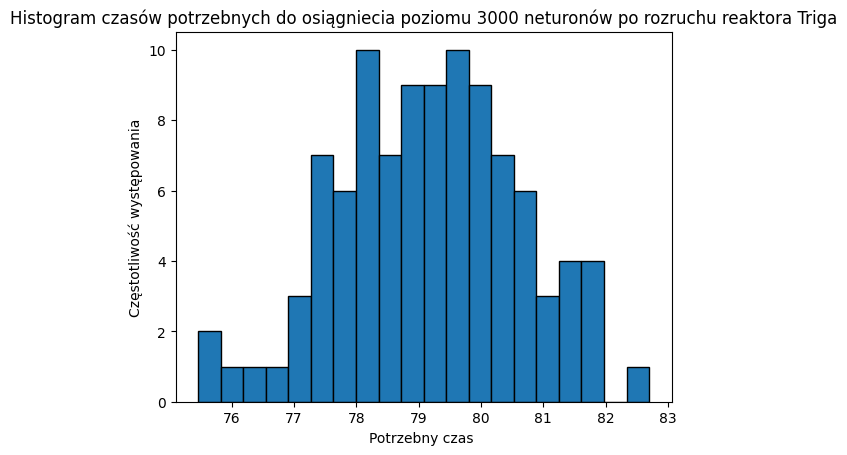

In [47]:
plt.hist(table,bins=20,edgecolor='black')
plt.title(f"Histogram czasów potrzebnych do osiągniecia poziomu {Level:} neturonów po rozruchu reaktora Triga")
plt.xlabel("Potrzebny czas ")
plt.ylabel("Częstotliwość występowania")
plt.show()

In [48]:
mean_level=np.mean(table)
std_level=np.std(table,ddof=1)

In [49]:
df=pd.DataFrame(columns=['E(Time)','std(Time)'])
df.loc[len(df)]=[mean_level,std_level]

In [50]:
df

,E(Time),std(Time)
0,79.16944,1.439643


# Symulacje numeryczne
Poniżej znajdują się symulacje dla danych testowych. Symulowana jest wartość oczekiwana i odchylenie standardowe poziomu neutronów w końcowym punkcie przedziału $T=0.1$ oraz rząd metody

In [15]:
lambda_=[0.0127,0.0317,0.115,0.311,1.4,3.87]#dane testowe
beta_=[0.000266,0.001491,0.001316,0.002849,0.000896,0.000182]
T=0.1
l=0.00002
beta=0.007
q=0.0
ro=0.003#stan stabilny
#ro=0.007# stan krytyczny szybki przyrost neutornow
niu=2.5
x_0=[1]
for i in range(1,7):
    x_0.append(beta_[i-1]/(lambda_[i-1]*l))
x_0=np.array(x_0)
x_0=100*x_0
gamma=(-1-ro+2*beta+(1-beta)**2*niu)/l

In [27]:
suma=0
d=500
n=1000
wsp=1/5
wsp8=wsp
ro=0.003
ro1=ro
storage=np.zeros(d)
storage2=np.zeros(n+1)
for i in range(d):
    x,t=Euler_maruyama(n)
    storage[i]=x[n,0]
    storage2+=x[:,0]
mean=np.mean(storage)
std=np.std(storage, ddof=1)
print(mean)
print(std)
mean_=storage2/d
df=pd.DataFrame(columns=['E(0.1s)','std(0.1s)','ro','wsp'])
df.loc[len(df)]=[mean,std,ro1,wsp8]

183.15176746077324
84.25242112347598


In [28]:
suma=0
d=500
n=1000
wsp=1
ro=0.003
ro2=ro
storage_=np.zeros(d)
storage2_=np.zeros(n+1)
for i in range(d):
    x_,t=Euler_maruyama(n)
    storage_[i]=x_[n,0]
    storage2_+=x_[:,0]
mean=np.mean(storage_)
std=np.std(storage_, ddof=1)
print(mean)
print(std)
mean_2=storage2_/d
df.loc[len(df)]=[mean,std,ro2,wsp]

185.21661642586992
172.3086207410579


In [29]:
suma=0
d=500
n=1000
wsp=1/5
wsp3=wsp
ro=0.007
ro3=ro
storage=np.zeros(d)
storage2=np.zeros(n+1)
for i in range(d):
    x_1,t=Euler_maruyama(n)
    storage[i]=x_1[n,0]
    storage2+=x_1[:,0]
mean=np.mean(storage)
std=np.std(storage, ddof=1)
print(mean)
print(std)
mean_3=storage2/d
df.loc[len(df)]=[mean,std,ro3,wsp3]

4488.486874242764
1988.0597933015003


In [30]:
suma=0
d=500
n=1000
wsp=1
wsp1=wsp
ro=0.007
ro4=ro
storage=np.zeros(d)
storage2=np.zeros(n+1)
for i in range(d):
    x_2,t=Euler_maruyama(n)
    storage[i]=x_2[n,0]
    storage2+=x_2[:,0]
mean=np.mean(storage)
std=np.std(storage, ddof=1)
print(mean)
print(std)
mean_4=storage2/d
df.loc[len(df)]=[mean,std,ro4,wsp1]

4798.957070771955
4740.888104319219


In [31]:
df

,E(0.1s),std(0.1s),ro,wsp
0,183.151767,84.252421,0.003,0.2
1,185.216616,172.308621,0.003,1.0
2,4488.486874,1988.059793,0.007,0.2
3,4798.957071,4740.888104,0.007,1.0


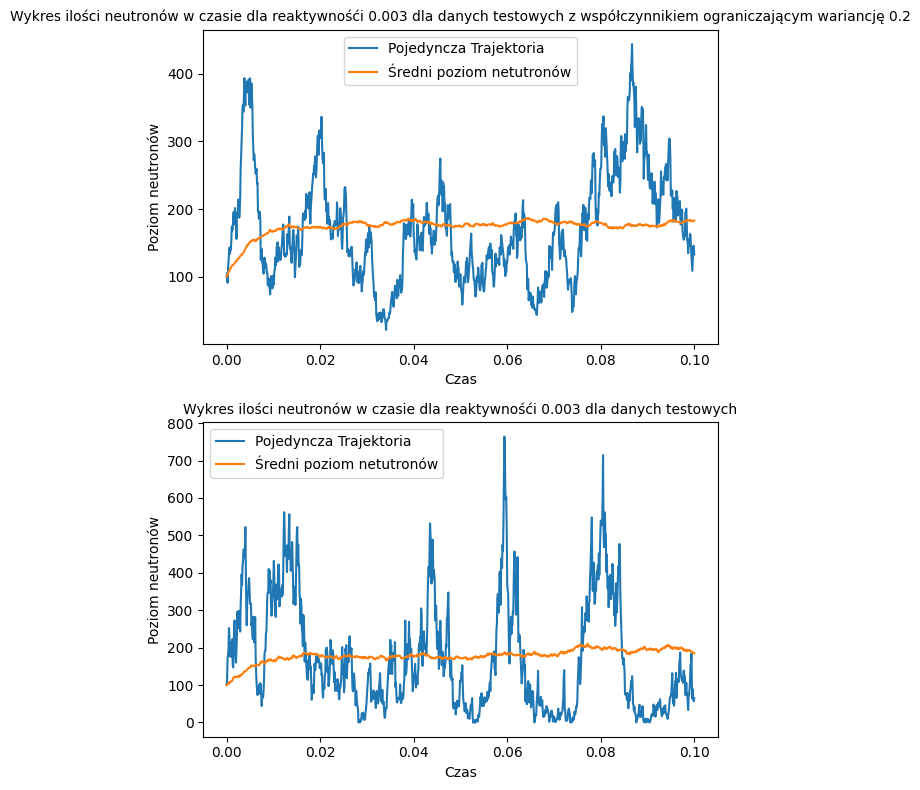

In [51]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,8))

ax1.plot(t,x[:,0])
ax1.plot(t,mean_)
ax1.legend(['Pojedyncza Trajektoria','Średni poziom netutronów'])
ax1.set_xlabel("Czas")
ax1.set_title(f"Wykres ilości neutronów w czasie dla reaktywnośći {ro1:} dla danych testowych z współczynnikiem ograniczającym wariancję {wsp8:}", fontsize=10)
ax1.set_ylabel("Poziom neutronów")
ax2.plot(t,x_[:,0])
ax2.plot(t,mean_2)
ax2.legend(['Pojedyncza Trajektoria','Średni poziom netutronów'])
ax2.set_xlabel("Czas")
ax2.set_title(f"Wykres ilości neutronów w czasie dla reaktywnośći {ro2:} dla danych testowych", fontsize=10)
ax2.set_ylabel("Poziom neutronów")
plt.tight_layout()
plt.show()

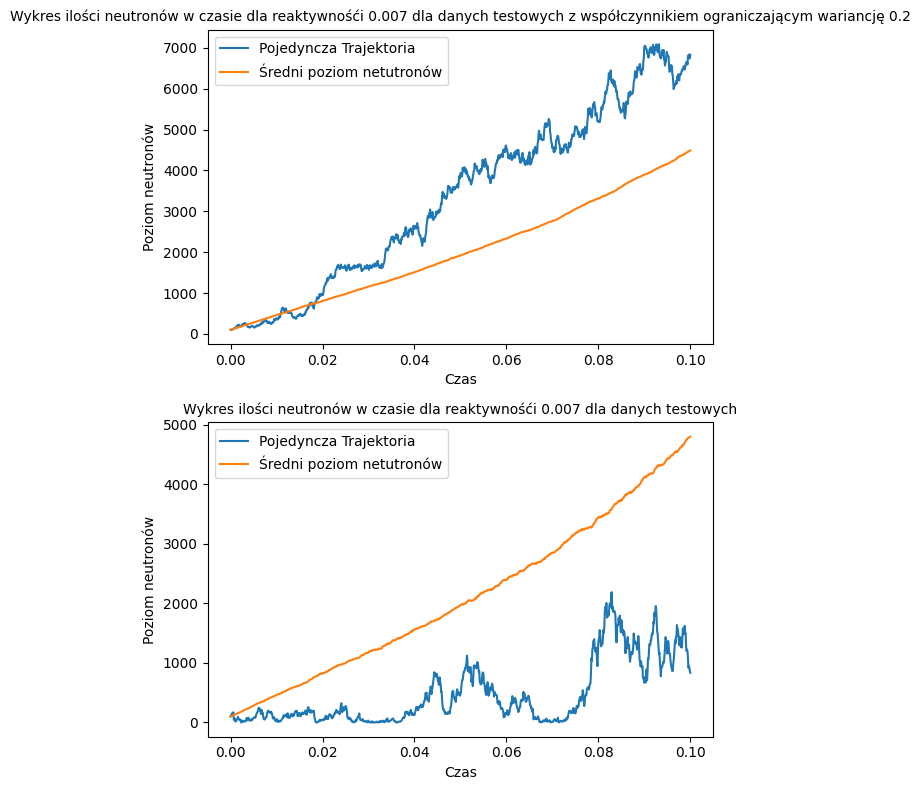

In [40]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,8))

ax1.plot(t,x_1[:,0])
ax1.plot(t,mean_3)
ax1.legend(['Pojedyncza Trajektoria','Średni poziom netutronów'])
ax1.set_xlabel("Czas")
ax1.set_title(f"Wykres ilości neutronów w czasie dla reaktywnośći {ro3:} dla danych testowych z współczynnikiem ograniczającym wariancję {wsp3:}", fontsize=10)
ax1.set_ylabel("Poziom neutronów")
ax2.plot(t,x_2[:,0])
ax2.plot(t,mean_4)
ax2.legend(['Pojedyncza Trajektoria','Średni poziom netutronów'])
ax2.set_xlabel("Czas")
ax2.set_title(f"Wykres ilości neutronów w czasie dla reaktywnośći {ro4:} dla danych testowych", fontsize=10)
ax2.set_ylabel("Poziom neutronów")
plt.tight_layout()
plt.show()

In [ ]:
T=0.1
num_iters=50
wsp=0.2
ro=0.003
n_list=[]
lista1=np.zeros(num_iters)
lista2=np.zeros(5)
for idx,i in enumerate(range(2,7)):
    n=5*np.power(2,i)
    n_list.append(n)
    for j in range(num_iters):
        lista1[j]=Error(n,1000)
    lista2[idx]=np.mean(lista1)
    

In [23]:
lista2
zeros=np.zeros(len(lista2))

In [24]:
df=pd.DataFrame(columns=['N','log(N)','Error','log(Error)','iloraz','log(iloraz)'])
for n, e, i in zip(n_list, lista2, zeros):
    df.loc[len(df)] = [n,np.log2(n), e,np.log2(e), i, i]
df['iloraz']=df['Error']/df['Error'].shift(-1)
df['log(iloraz)']=np.log2(df['iloraz'])

In [25]:
df

,N,log(N),Error,log(Error),iloraz,log(iloraz)
0,20.0,4.321928,40.633030,5.344581,2.038248,1.027329
1,40.0,5.321928,19.935277,4.317252,1.796615,0.845281
2,80.0,6.321928,11.096022,3.471971,1.967421,0.976305
3,160.0,7.321928,5.639883,2.495665,1.148718,0.200025
4,320.0,8.321928,4.909719,2.295641,NaN,NaN


In [26]:
slope, intercept,_,_,_ = stats.linregress(df['log(N)'],df['log(Error)'])

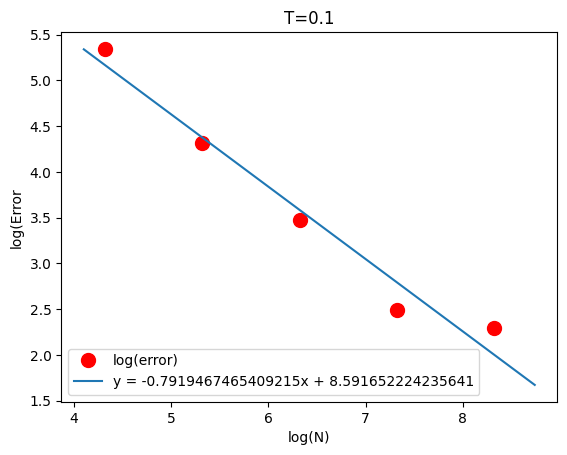

In [27]:
low=np.min(np.log2(n_list))
up=np.max(np.log2(n_list))
Lin = np.linspace(low*0.95,up*1.05,500)
plt.plot(df['log(N)'],df['log(Error)'],'o',markersize=10,color='red', label='log(error)')
plt.plot(Lin, slope*Lin+intercept, label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log(N)')
plt.title(f"T={T:}")
plt.ylabel('log(Error')
plt.legend()
plt.show()

In [7]:
T=1.0
num_iters=50
wsp=0.2
ro=0.003
n_list=[]
lista1=np.zeros(num_iters)
lista2=np.zeros(5)
for idx,i in enumerate(range(2,7)):
    n=5*np.power(2,i)
    n_list.append(n)
    for j in range(num_iters):
        lista1[j]=Error(n,1000)
    lista2[idx]=np.mean(lista1)
    

In [8]:
lista2
zeros=np.zeros(len(lista2))

In [9]:
df=pd.DataFrame(columns=['N','log(N)','Error','log(Error)','iloraz','log(iloraz)'])
for n, e, i in zip(n_list, lista2, zeros):
    df.loc[len(df)] = [n,np.log2(n), e,np.log2(e), i, i]
df['iloraz']=df['Error']/df['Error'].shift(-1)
df['log(iloraz)']=np.log2(df['iloraz'])

In [10]:
df

,N,log(N),Error,log(Error),iloraz,log(iloraz)
0,20.0,4.321928,9.888081e+20,69.744252,8.157543e-06,-16.903434
1,40.0,5.321928,1.212140e+26,86.647686,4.431482e+09,32.045142
2,80.0,6.321928,2.735292e+16,54.602544,3.189847e+14,48.180480
3,160.0,7.321928,8.574994e+01,6.422064,2.391029e+00,1.257632
4,320.0,8.321928,3.586320e+01,5.164432,NaN,NaN


W powyższym przykładzie możemy dostrzec pewną niestabilność równania dla kroków wielkości $ h<=1/80 $

In [11]:
slope, intercept,_,_,_ = stats.linregress(df['log(N)'],df['log(Error)'])

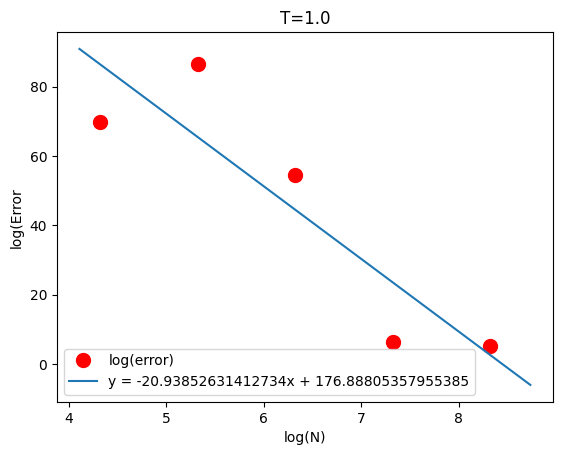

In [12]:
low=np.min(np.log2(n_list))
up=np.max(np.log2(n_list))
Lin = np.linspace(low*0.95,up*1.05,500)
plt.plot(df['log(N)'],df['log(Error)'],'o',markersize=10,color='red', label='log(error)')
plt.plot(Lin, slope*Lin+intercept, label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log(N)')
plt.title(f"T={T:}")
plt.ylabel('log(Error')
plt.legend()
plt.show()